#### Author: Arun Ramesh, University of Houston. https://rpglab.github.io/people/Arun-Venkatesh-Ramesh/
#### Source webpage: https://rpglab.github.io/resources/FL-ML-R-SCUC_Python/
#### If you use any codes/data here for your work, please cite the following paper: 
#####       Arun Venkatesh Ramesh and Xingpeng Li, “Feasibility Layer Aided Machine Learning Approach for Day-Ahead Operations”, IEEE Transactions on Power Systems, Apr. 2023.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
np.random.seed(1)

import sys
nums = np.arange(2000)
np.set_printoptions(threshold=sys.maxsize)

import csv
import time
from timeit import default_timer as timer

In [2]:
##### data set 24 Bus 8 Prd

dfX_24 = pd.read_csv("demand24Bus24Prd.txt")
dfY_24 = pd.read_csv("commitment24Bus24Prd.txt")

print(dfX_24.info)
print(dfY_24.info)

x = dfX_24.to_numpy()

# normalize X with Base MVA
x = x/100
#print(x[1])

y = dfY_24.to_numpy()
#print(y[1])

# Shuffle (x, y) in unison as the later parts of x will almost all be larger digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 20% for validation data that we never train over.
split_at = len(x) - len(x) // 5
(x_train, x_test) = x[:split_at], x[split_at:]
(y_train, y_test) = y[:split_at], y[split_at:]


print(len(x_train))
print(len(y_train))

print(len(x_test))
print(len(y_test))

print(indices)

#print(x_train[1])
#print(y_train[1])

#print(x_test[1])
#print(y_test[1])

<bound method DataFrame.info of       90.13728903773256  80.95663922833387  75.11440753144379  \
0             67.493145          60.618843          56.244287   
1            107.022171          96.121765          89.185142   
2            108.926408          97.832052          90.772007   
3             62.949194          56.537702          52.457662   
4             95.801737          86.044153          79.834781   
...                 ...                ...                ...   
1494         101.205071          83.534633          79.818072   
1495          84.521178          78.343324          74.534879   
1496          92.821142          84.133780          89.090335   
1497          78.007085          86.473328          79.682256   
1498          85.612332          75.013867          67.089895   

      128.52909733158162  59.25692149702789  123.5214701628187  \
0              96.240225          44.370493          92.490606   
1             152.605688          70.357168         146

In [3]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(1200, 576)
(1200, 792)
(299, 576)
(299, 792)


In [4]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, nTargets) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros(shape=(dim,792))
    b = 0
    return w, b

In [5]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1. / ( 1 + np.exp(-z))
    return s

In [6]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- trainable weights 
    b -- bias, a scalar
    X -- data normalized demand
    Y -- Actual commitment schedules

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w
    db -- gradient of the loss with respect to b
    """
    
    m = X.shape[0]
    
    #print(m)
    #print(w.shape)
    #print(X.shape)
    b = np.sum(b) #try b.T
        
    # Forward propagation (costs)
    A = sigmoid(np.dot(w.T, X) + b)             # compute activation
    #print(A.shape)
    #print(Y.shape)
    cost = (-1. / m) * np.sum((Y*np.log(A) + (1 - Y)*np.log(1-A)), axis=1)    # compute cost
    #print(cost.shape)
    
    # Backward Propagartion (gradients)
    dw = (1./m)*np.dot(X,((A-Y).T))
    db = (1./m)*np.sum(A-Y, axis=1)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == (792,))
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [7]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- trainable weights 
    b -- bias, a scalar
    X -- data normalized demand
    Y -- Actual commitment schedules
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 training iterations
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate*dw
        b = b -  learning_rate*db
        
        # Record the costs
        #if i % 100 == 0:
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [8]:
def predict(w, b, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- trainable weights 
    b -- bias, a scalar
    X -- data normalized demand
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions in % for the examples in X
    """
    
    m = X.shape[1]
    #Y_prediction = np.zeros((792, m))
    w = w.reshape(X.shape[0], 792)
    b = np.sum(b)
    
    # Compute vector "A" predicting the probabilities commitment
    A = sigmoid(np.dot(w.T, X) + b)
    #print (A.shape)
    #print(A.T)        
    return A

In [9]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.005, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training input set 
    Y_train -- training target set
    X_test -- test set 
    Y_test -- test targets
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost for every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
       
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
       
    d = {"costs": costs,
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [10]:
x_train = x_train.T
y_train = y_train.T

x_test = x_test.T
y_test = y_test.T

In [11]:
print (x_train.shape)
print (y_train.shape)

learning_rates = [0.001, 0.003, 0.005, 0.008, 0.01, 0.03] #0.05 too high

models = {}
for i in learning_rates:
    start = timer()
    print ("learning rate is: ",i)
    models[i] = model(x_train, y_train, x_test, y_test, num_iterations = 1000, learning_rate = i, print_cost = False)
    end = timer()
    print("training time: ",end - start)
    print ("-------------------------------------------------------")

(576, 1200)
(792, 1200)
learning rate is:  0.001
training time:  64.32855149999999
-------------------------------------------------------
learning rate is:  0.003
training time:  63.2479374
-------------------------------------------------------
learning rate is:  0.005
training time:  64.9443891
-------------------------------------------------------
learning rate is:  0.008
training time:  64.85721559999999
-------------------------------------------------------
learning rate is:  0.01
training time:  63.42553680000003
-------------------------------------------------------
learning rate is:  0.03
training time:  64.03142860000003
-------------------------------------------------------


In [12]:
for i in learning_rates:
    print ("learning rate is: ",i)
    w = models[i]["w"]
    b = models[i]["b"]
    A_prediction_test = predict(w, b, x_test)
    A_prediction_test = A_prediction_test.T
    
    m = A_prediction_test.shape[0]
    Y_test_hackFull = np.zeros((m,A_prediction_test.shape[1]))
    P = 0.5

    for j in range(m):
        for i in range(A_prediction_test.shape[1]):
        
            # Convert probabilities A[0,i] to actual predictions p[0,i]
            if A_prediction_test[j, i] >= P:
                Y_test_hackFull[j, i] = 1
            
            else:
                Y_test_hackFull[j, i] = 0
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test.T - Y_test_hackFull)) * 100))
    
    A_prediction_train = predict(w, b, x_train)
    A_prediction_train = A_prediction_train.T
    
    m = A_prediction_train.shape[0]
    Y_train_hackFull = np.zeros((m,A_prediction_train.shape[1]))
    
    for j in range(m):
        for i in range(A_prediction_train.shape[1]):
        
            # Convert probabilities A[0,i] to actual predictions p[0,i]
            if A_prediction_train[j, i] >= P:
                Y_train_hackFull[j, i] = 1
            
            else:
                Y_train_hackFull[j, i] = 0
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train.T - Y_train_hackFull)) * 100))
    print ("-------------------------------------------------------")

learning rate is:  0.001
test accuracy: 96.98363230971927 %
train accuracy: 97.04850589225589 %
-------------------------------------------------------
learning rate is:  0.003
test accuracy: 97.07780142562751 %
train accuracy: 97.08522727272727 %
-------------------------------------------------------
learning rate is:  0.005
test accuracy: 97.32061416844026 %
train accuracy: 97.37805134680134 %
-------------------------------------------------------
learning rate is:  0.008
test accuracy: 97.43336373771156 %
train accuracy: 97.4709595959596 %
-------------------------------------------------------
learning rate is:  0.01
test accuracy: 97.44941049288876 %
train accuracy: 97.4961069023569 %
-------------------------------------------------------
learning rate is:  0.03
test accuracy: 97.21504341069559 %
train accuracy: 97.29156144781145 %
-------------------------------------------------------


In [13]:
i = 0.01
print ("learning rate is: ",i)
w = models[i]["w"]
b = models[i]["b"]
A_prediction_test = predict(w, b, x_test)
A_prediction_test = A_prediction_test.T
    
m = A_prediction_test.shape[0]
Y_test_hackFull = np.zeros((m,A_prediction_test.shape[1]))
P = 0.5

for j in range(m):
    for k in range(A_prediction_test.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A_prediction_test[j, k] >= P:
            Y_test_hackFull[j, k] = 1
            
        else:
            Y_test_hackFull[j, k] = 0
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test.T - Y_test_hackFull)) * 100))
    
A_prediction_train = predict(w, b, x_train)
A_prediction_train = A_prediction_train.T
    
m = A_prediction_train.shape[0]
Y_train_hackFull = np.zeros((m,A_prediction_train.shape[1]))
    
for j in range(m):
    for k in range(A_prediction_train.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A_prediction_train[j, k] >= P:
            Y_train_hackFull[j, k] = 1
            
        else:
            Y_train_hackFull[j, k] = 0
print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train.T - Y_train_hackFull)) * 100))
print ("-------------------------------------------------------")

learning rate is:  0.01
test accuracy: 97.44941049288876 %
train accuracy: 97.4961069023569 %
-------------------------------------------------------


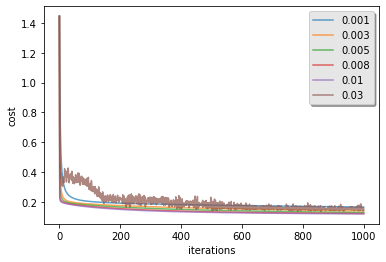

In [14]:
plt.clf()

NCost = int(models[0.01]["num_iterations"])#/100)

costarray_full = np.zeros((len(learning_rates),NCost))
costarray_single = np.zeros(NCost)

#print (NCost)
for i in range(6):#len(learning_rates)):
    costarray_single = np.zeros(NCost)
    for j in range(NCost):
        #print (j)
        costarray_single[j] = np.mean(np.squeeze(models[learning_rates[i]]["costs"][j])) 
    costarray_full[i] = costarray_single
    plt.plot(costarray_full[i], label= str(models[learning_rates[i]]["learning_rate"]),alpha=0.7)
    #print (np.squeeze(models[i]["costs"][2]))

#plt.plot(costarray_full[i], label= str(models[0.001]["learning_rate"]), alpha=1)
#plt.plot(np.squeeze(models[0.001]["costs"][1]), label= str(models[0.001]["learning_rate"]))
plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='best', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [15]:
# Perform comparison with Sklearn model

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
#from sklearn.preprocessing import StandardScaler # data normalization
#X_var = StandardScaler().fit(X_var).transform(x_train.T)

TrainScore = []
TestScore = []
NgxNt = y_train.shape[0]
m_Tr = x_train.shape[1]
m_Ts = x_test.shape[1]

Y_hat_tr_skln_pred = np.zeros((m_Tr,NgxNt))
Y_hat_ts_skln_pred = np.zeros((m_Ts,NgxNt))

start = timer()
for i in range(NgxNt):
    #print ("Ng*Nt: ",i)   
    
    if set([0,1]).issubset(set(y_train[i])):      
        
        #logreg = MultiOutputRegressor(LogisticRegression(multi_class='multinomial', solver='lbfgs'))
        logreg = LogisticRegression(random_state=0, solver='liblinear', max_iter = 100)
        logreg.fit(x_train.T,y_train[i]) #original shape before transposed
        Y_hat_tr_skln_pred[:,i] = logreg.predict(x_train.T)
        TrainScore.append(logreg.score(x_train.T,y_train[i]))
        Y_hat_ts_skln_pred[:,i] = logreg.predict(x_test.T)
        TestScore.append(logreg.score(x_test.T,y_test[i]))
    
    else:
        
        if set([0]).issubset(set(y_train[i])):
            Y_hat_tr_skln_pred[:,i] = np.zeros(m_Tr)
        else:
            Y_hat_tr_skln_pred[:,i] = np.ones(m_Tr)
        
        if set([0]).issubset(set(y_test[i])):
            Y_hat_ts_skln_pred[:,i] = np.zeros(m_Ts)
        else:
            Y_hat_ts_skln_pred[:,i] = np.ones(m_Ts)
            
        TrainScore.append(1)
        TestScore.append(1)
end = timer()
print("training time: ",end - start)
print ("-------------------------------------------------------")

print("training Score: ", np.mean(TrainScore))
print("testing Score: ", np.mean(TestScore))

print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train.T - Y_hat_tr_skln_pred)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test.T - Y_hat_ts_skln_pred)) * 100))

training time:  17.11743469999999
-------------------------------------------------------
training Score:  0.9795717592592592
testing Score:  0.9755413668457147
train accuracy: 97.95717592592592 %
test accuracy: 97.55202526941657 %


In [17]:
print(Y_hat_tr_skln_pred[1])

[0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [18]:
# Compare with mltr for same number of iterations

start = timer()
print ("learning rate is 0.01 ")
models[i] = model(x_train, y_train, x_test, y_test, num_iterations = 100, learning_rate = 0.01, print_cost = False)
end = timer()
print("training time: ",end - start)
print ("-------------------------------------------------------")

learning rate is 0.01 
training time:  6.479523300000039
-------------------------------------------------------


In [1]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, random_state=1)

print (X.shape)
print (y.shape)
print (X)
print (y)

(100, 20)
(100,)
[[ 0.6065484   0.81695766  1.05132077 ... -0.36453805  0.16466507
  -0.76780375]
 [-3.05376438  0.92116205 -1.45832446 ...  0.20437739 -1.55269878
  -0.4466992 ]
 [ 0.60640394  0.68064537  1.02124813 ...  1.03703898 -0.83001099
  -0.03599018]
 ...
 [-2.30803851 -1.42368943  1.14256392 ... -0.24701649 -0.37911961
   0.27610275]
 [-1.53702887  2.14957042  0.32455352 ...  2.15323347  1.31972591
  -0.8797298 ]
 [ 0.37167029 -0.95543218 -0.1484898  ... -0.6294416   0.14225137
   0.78002714]]
[1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1
 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 0 0 1 1
 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0]
